#### Gen-AI creating books for toddlers 
###### image and text generation with llama and stable diffusion

In [1]:
from IPython.display import Markdown,display
from diffusers import BitsAndBytesConfig, SD3Transformer2DModel
from diffusers import StableDiffusion3Pipeline

import torch
torch.cuda.empty_cache()
import gc
gc.collect()

from transformers import pipeline
import json
import re

#Loading Llama
device = "cuda" if torch.cuda.is_available() else "cpu"
llama_32 = pipeline(model="meta-llama/Llama-3.2-1B-Instruct", device=device, torch_dtype=torch.bfloat16)




model_id = "stabilityai/stable-diffusion-3.5-medium"

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,    bnb_4bit_quant_type="nf4",    bnb_4bit_compute_dtype=torch.bfloat16)

model_nf4 = SD3Transformer2DModel.from_pretrained(
    model_id,    subfolder="transformer",    quantization_config=nf4_config,    torch_dtype=torch.bfloat16)

stable_diffusion = StableDiffusion3Pipeline.from_pretrained(
    model_id,     transformer=model_nf4,    torch_dtype=torch.bfloat16)
stable_diffusion.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [2]:
def create_content(generator, messages):
    generation= generator(
        messages,    do_sample=True,
        temperature=0.7,        top_p=0.9,        max_new_tokens=1000,
        pad_token_id=generator.tokenizer.eos_token_id
    )
    return generation[0]['generated_text'][-1]['content']

Let's create a prompt that will always have the same format so it's easier to extract the data.

# Llama

In [3]:
prompt = [
    {"role": "system", "content": "You are a creative writer for toddlers."},
    {"role": "user", "content": 
     """Create a story for a book with 5 pages. Each page must have:
        - One or two short sentences (maximum two sentences).
        - A description of the image to appear on the page.
        Choose a random theme: astronauts, dinosaurs, an animal, fairy tales, pets or anything else, be creative.
        The output must be a JSON array with this format, nothing more, using markdown to display the json. (```json)
        [{"sentence":"Sentence for page 1","image":"Description for page 1 image"},
         {"sentence":"Sentence for page 2","image":"Description for page 2 image"},
         {"sentence":"Sentence for page 3","image":"Description for page 3 image"},
         {"sentence":"Sentence for page 4","image":"Description for page 4 image"},
         {"sentence":"Sentence for page 5","image":"Description for page 5 image"}]
        """}
]


response = create_content(llama_32, prompt) #Return from the model
output = json.loads(re.findall("```json(.*?)```" , response, re.DOTALL)[0]) #Treating to catch only the json content
print(json.dumps(output, indent=4, ensure_ascii=False))  #Printing to validate


[
    {
        "sentence": "Once upon a time, in a land far, far away, a friendly dragon named Sparky lived in a cozy cave.",
        "image": "A colorful illustration of a cave with Sparky the dragon sitting on a rock, wearing a friendly smile."
    },
    {
        "sentence": "One day, a brave little girl named Lily wandered into the cave, searching for a place to play.",
        "image": "A whimsical illustration of Lily, a little girl with a big smile, peeking into Sparky's cave, with a curious expression on her face."
    },
    {
        "sentence": "Sparky welcomed Lily with open arms and introduced her to his best friend, a silly rabbit named Fluffy.",
        "image": "A heartwarming illustration of Sparky and Fluffy hugging, with Lily in the background, looking happy and a bit surprised."
    },
    {
        "sentence": "Together, the three friends went on an adventure, exploring the magical forest and playing hide-and-seek among the trees.",
        "image": "A beautiful 

That story looks interesting(maybe crazy) right :) 

# Stable Diffusion

Below we are going to use stable difussion to create the images, that are much better models as of today, but this one I can load on my machine (and do 1 round)

Sentence Once upon a time, in a land far, far away, a friendly dragon named Sparky lived in a cozy cave.
Details of image A colorful illustration of a cave with Sparky the dragon sitting on a rock, wearing a friendly smile.


  0%|          | 0/30 [00:00<?, ?it/s]

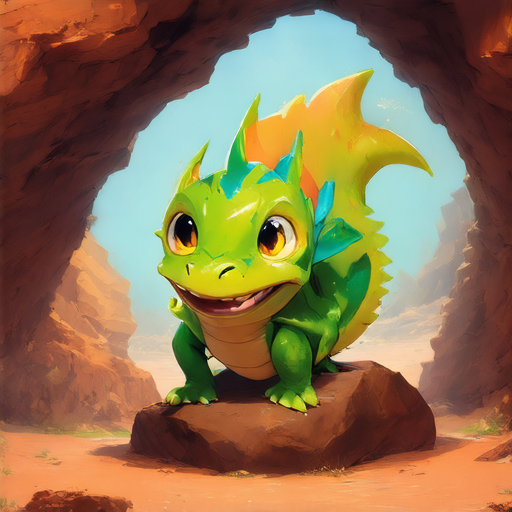

In [4]:
images=[]
for page in output[:1]: # I am running on my persoanl computer, so to be quick just 2 pages is enough to try :)
    print("Sentence",page['sentence'])
    print("Details of image",page["image"])
    image = stable_diffusion(
    page['image']+""", designed in a cartoon style. pastel colors, rounded shapes, thick outlines, and flat shading. 
background is minimalistic. Soft facial expressions.
""",
    num_inference_steps=30,
    guidance_scale=4.5,
        height=512, 
    width=512   ).images[0]
    display(image)
    images.append(image)


Welcome to life Sparky 

Let's add the sentence inside the image

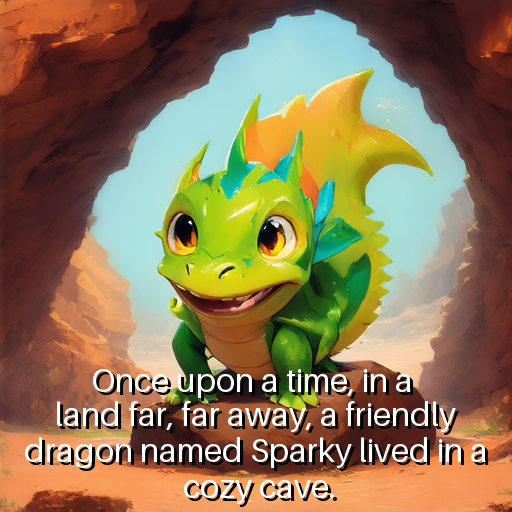

In [48]:
from PIL import Image, ImageDraw, ImageFont 

text_ajust=[]
i=0
for word in output[0]['sentence'].split(' '):
    i+=1
    if i%6==0 or (i>4 and ',' in word):
        i=0
        text_ajust.append(word)
        text_ajust.append('\n')
    else:
        text_ajust.append(word)
    

text_ajust=' '.join(text_ajust)

font_size = int(image.height * 0.065)
font = ImageFont.load_default(font_size)
image_text = Image.new("RGBA", image.size, (255, 255, 255, 0))
draw = ImageDraw.Draw(image_text)

lines = text_ajust.split("\n")
y = image.height - font_size - 120

for line in lines:
    text_bbox = draw.textbbox((0, 0), line, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    
    x = (image.width - text_width) // 2
    draw.text((x + 3, y + 3), line, font=font, fill="black")
    draw.text((x, y), line, font=font, fill="white")   
    y += text_height + 5

image_final = Image.alpha_composite(image.convert("RGBA"), image_text)
image_final.show()